<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C3/blob/main/W2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Deep N-grams
Welcome to the second assignment of course 3. In this assignment you will explore Recurrent Neural Networks RNN.

You will be using the fundamentals of google's trax package to implement any kind of deeplearning model.
By completing this assignment, you will learn how to implement models from scratch:

* How to convert a line of text into a tensor
* Create an iterator to feed data to the model
* Define a GRU model using trax
* Train the model using trax
* Compute the accuracy of your model using the perplexity
* Predict using your own model

## Overview
Your task will be to predict the next set of characters using the previous characters.

* Although this task sounds simple, it is pretty useful.
* You will start by converting a line of text into a tensor
* Then you will create a generator to feed data into the model
* You will train a neural network in order to predict the new set of characters of defined length.
* You will use embeddings for each character and feed them as inputs to your model.
  * Many natural language tasks rely on using embeddings for predictions.
* Your model will convert each character to its embedding, run the embeddings through a Gated Recurrent Unit GRU, and run it through a linear layer to predict the next set of characters.

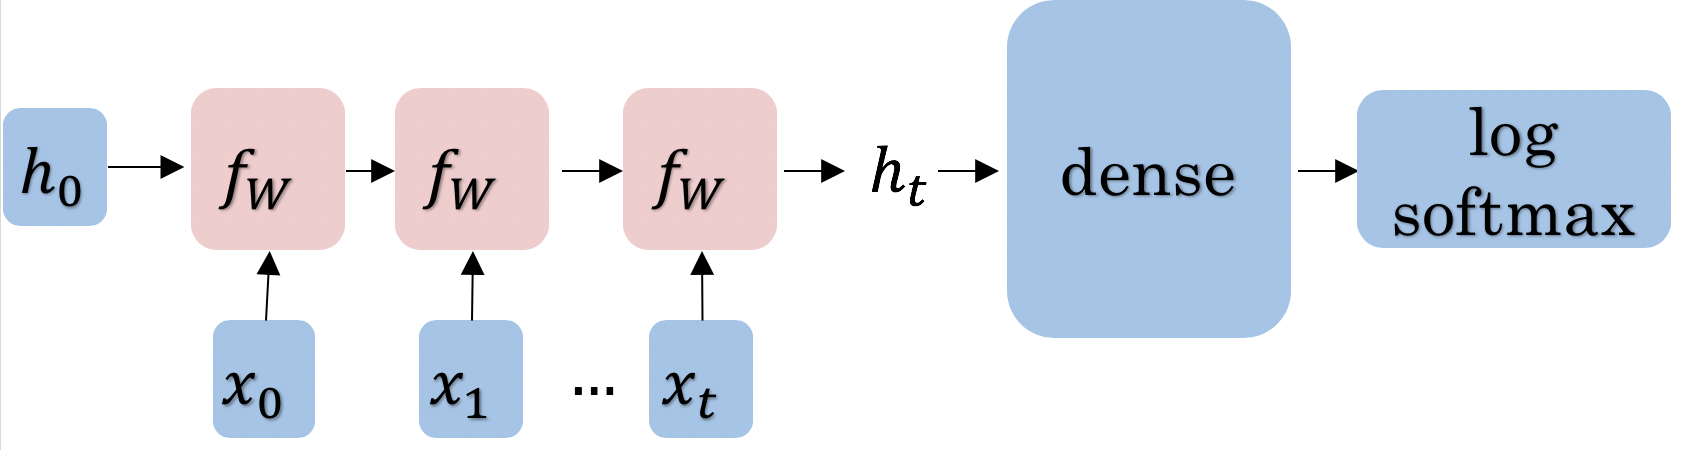

The figure above gives you a summary of what you are about to implement.

* You will get the embeddings;
* Stack the embeddings on top of each other;
* Run them through two layers with a relu activation in the middle;
* Finally, you will compute the softmax.

To predict the next character:

* Use the softmax output and identify the word with the highest probability.
* The word with the highest probability is the prediction for the next word.

In [46]:
!pip install sentencepiece==0.1.91
!pip install trax

import trax
import trax.fastmath.numpy as np

import os
import pickle
import numpy
from trax import fastmath
from trax import layers as tl
import random as rnd
from trax.supervised import training

# Part 1: Importing the Data

## 1.1 Loading in the data

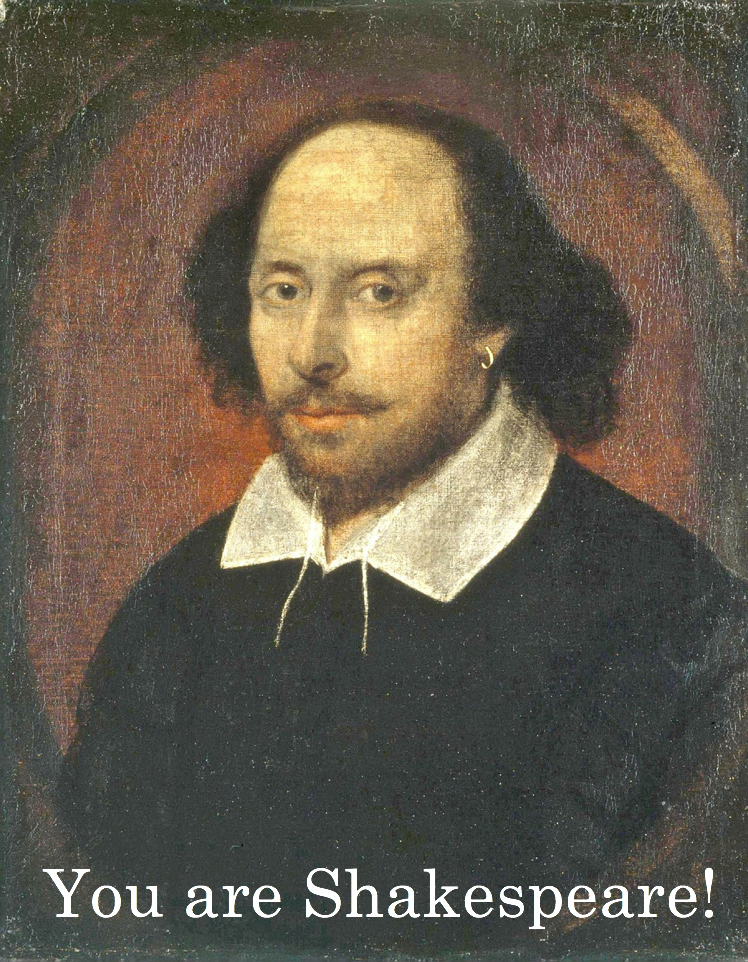

In [47]:
!git clone -l -s https://github.com/DrAlexSanz/NLP-SPEC-C3.git Repo
%cd Repo
%rm -rf W1
%mv ./W2/* ./
%rm -rf W2

Cloning into 'Repo'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 148 (delta 8), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (148/148), 8.04 MiB | 26.72 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/Repo


In [48]:
# Now import data.

dirname = "data/"
lines = []

for filename in os.listdir(dirname):
    with open(os.path.join(dirname, filename)) as file:
        for line in file:
            clean_line = line.strip()

            if clean_line: # Is not empty
                lines.append(clean_line)

In [49]:
#Check it

n_lines = len(lines)
print("Number of lines is:", n_lines)
print(f"Sample line 0 is {lines[0]}")
print(f"Sample line 13 is {lines[13]}")

Number of lines is: 125098
Sample line 0 is KING RICHARD II
Sample line 13 is LORD BERKELEY:


Notice that the letters are both uppercase and lowercase. In order to reduce the complexity of the task, we will convert all characters to lowercase. This way, the model only needs to predict the likelihood that a letter is 'a' and not decide between uppercase 'A' and lowercase 'a'.

In [50]:
for i, line in enumerate(lines):
    lines[i] = line.lower()

In [51]:
# Check it. Probably I can remove the first line in every document because it will contain the title but that should be OK. They are a few out of 125.000 lines.
print(f"Sample line 0 is {lines[0]}")
print(f"Sample line 13 is {lines[13]}")

Sample line 0 is king richard ii
Sample line 13 is lord berkeley:


In [52]:
eval_lines = lines[-1000:] # Create a holdout validation set
lines = lines[:-1000] # Leave the rest for training

print(f"Number of lines for training: {len(lines)}")
print(f"Number of lines for validation: {len(eval_lines)}")

Number of lines for training: 124098
Number of lines for validation: 1000


## 1.2 Convert a line to tensor
Now that you have your list of lines, you will convert each character in that list to a number. You can use Python's ord function to do it.

Given a string representing of one Unicode character, the ord function return an integer representing the Unicode code point of that character.

### **This is a hacky way to tokenize the sentences**

In [53]:
print(f"ord(a) = {ord('x')}") # Double quotes confuse the interpreter

ord(a) = 120


### Exercise 01
Instructions: Write a function that takes in a single line and transforms each character into its unicode integer. This returns a list of integers, which we'll refer to as a tensor.

* Use a special integer to represent the end of the sentence (the end of the line).
* This will be the EOS_int (end of sentence integer) parameter of the function.
* Include the EOS_int as the last integer of the
* For this exercise, you will use the number 1 to represent the end of a sentence.

In [54]:
def line_to_tensor(line, EOS_int = 1):
    "Get a line (words) and return the Unicode number as a token"

    tensor = []
    for c in line:
        tensor.append(ord(c))

    tensor.append(EOS_int)

    return tensor

In [55]:
#test. Note the 1 at the end

test_line = line_to_tensor("abc xyz cipote")
print(test_line)

[97, 98, 99, 32, 120, 121, 122, 32, 99, 105, 112, 111, 116, 101, 1]


## 1.3 Batch generator
Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets. Here, you will build a data generator that takes in a text and returns a batch of text lines (lines are sentences).

The generator converts text lines (sentences) into numpy arrays of integers padded by zeros so that all arrays have the same length, which is the length of the longest sentence in the entire data set.
Once you create the generator, you can iterate on it like this:

`next(data_generator)`

This generator returns the data in a format that you could directly use in your model when computing the feed-forward of your algorithm. This iterator returns a batch of lines and per token mask. The batch is a tuple of three parts: inputs, targets, mask. The inputs and targets are identical. The second column will be used to evaluate your predictions. Mask is 1 for non-padding tokens.


##Exercise 02
Instructions: Implement the data generator below. Here are some things you will need.

* While True loop: this will yield one batch at a time.
if index >= num_lines, set index to 0.
* The generator should return shuffled batches of data. To achieve this without modifying the actual lines a list containing the indexes of data_lines is created. This list can be shuffled and used to get random batches everytime the index is reset.
* if len(line) < max_length append line to cur_batch.
  * Note that a line that has length equal to max_length should not be appended to the batch.
  * This is because when converting the characters into a tensor of integers, an additional end of sentence token id will be added.
  * So if max_length is 5, and a line has 4 characters, the tensor representing those 4 characters plus the end of sentence character will be of length 5, which is the max length.
* if len(cur_batch) == batch_size, go over every line, convert it to an int and store it.

**Remember that when calling np you are really calling trax.fastmath.numpy which is trax’s version of numpy that is compatible with JAX. As a result of this, where you used to encounter the type numpy.ndarray now you will find the type jax.interpreters.xla.DeviceArray.**

* Use the line_to_tensor function above inside a list comprehension in order to pad lines with zeros.
* Keep in mind that the length of the tensor is always 1 + the length of the original line of characters. Keep this in mind when setting the padding of zeros.

In [56]:
def data_generator(batch_size, max_length, data_lines, line_to_tensor = line_to_tensor, shuffle = True):
    """Generator function that yields batches of data

    Args:
        batch_size (int): number of examples (in this case, sentences) per batch.
        max_length (int): maximum length of the output tensor.
        NOTE: max_length includes the end-of-sentence character that will be added
                to the tensor.  
                Keep in mind that the length of the tensor is always 1 + the length
                of the original line of characters.
        data_lines (list): list of the sentences to group into batches.
        line_to_tensor (function, optional): function that converts line to tensor. Defaults to line_to_tensor.
        shuffle (bool, optional): True if the generator should generate random batches of data. Defaults to True.

    Yields:
        tuple: two copies of the batch (jax.interpreters.xla.DeviceArray) and mask (jax.interpreters.xla.DeviceArray).
        NOTE: jax.interpreters.xla.DeviceArray is trax's version of numpy.ndarray. Because they needed to create their own library
    """

    index = 0
    
    # initialize the list that will contain the current batch
    cur_batch = []
    
    # count the number of lines in data_lines
    num_lines = len(data_lines)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle line indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    while True:
        
        # if the index is greater or equal than to the number of lines in data_lines
        if index >= num_lines:
            # then reset the index to 0
            index = 0
            # shuffle line indexes if shuffle is set to True
            if shuffle:
                rnd.shuffle(lines_index)
            
        # get a line at the `lines_index[index]` position in data_lines
        line = data_lines[lines_index[index]]
        
        # if the length of the line is less than max_length
        if len(line) < max_length:
            # append the line to the current batch
            cur_batch.append(line)
            
        # increment the index by one
        index += 1
        
        # if the current batch is now equal to the desired batch size
        if len(cur_batch) == batch_size:
            
            batch = []
            mask = []
            
            # go through each line (li) in cur_batch
            for li in cur_batch:
                # convert the line (li) to a tensor of integers
                tensor = line_to_tensor(li)
                
                # Create a list of zeros to represent the padding
                # so that the tensor plus padding will have length `max_length`
                pad = [0] * (max_length - len(tensor))
                
                # combine the tensor plus pad
                tensor_pad = tensor + pad
                
                # append the padded tensor to the batch
                batch.append(tensor_pad)

                # A mask for  tensor_pad is 1 wherever tensor_pad is not
                # 0 and 0 wherever tensor_pad is 0, i.e. if tensor_pad is
                # [1, 2, 3, 0, 0, 0] then example_mask should be
                # [1, 1, 1, 0, 0, 0]
                # Hint: Use a list comprehension for this
                example_mask = [0 if t == 0 else 1 for t in tensor_pad]
                mask.append(example_mask)
               
            # convert the batch (data type list) to a trax's numpy array
            batch_np_arr = np.array(batch)
            mask_np_arr = np.array(mask)
            
            ### END CODE HERE ##
            
            # Yield two copies of the batch and mask.
            yield batch_np_arr, batch_np_arr, mask_np_arr
            
            # reset the current batch to an empty list
            cur_batch = []

In [57]:
tmp_lines = ['12345678901', #length 11
             '123456789', # length 9
             '234567890', # length 9
             '345678901'] # length 9

# Get a batch size of 2, max length 10
tmp_data_gen = data_generator(batch_size=2, 
                              max_length=10, 
                              data_lines=tmp_lines,
                              shuffle=False)

# get one batch
tmp_batch = next(tmp_data_gen)

# view the batch
tmp_batch

(DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32))

Now that you have your generator, you can just call them and they will return tensors which correspond to your lines in Shakespeare. The first column and the second column are identical. Now you can go ahead and start building your neural network.

## 1.4 Repeating Batch generator
The way the iterator is currently defined, it will keep providing batches forever.

Although it is not needed, we want to show you the itertools.cycle function which is really useful when the generator eventually stops

Notice that it is expected to use this function within the training function further below

Usually we want to cycle over the dataset multiple times during training (i.e. train for multiple epochs).

For small datasets we can use itertools.cycle to achieve this easily.

In [58]:
import itertools

infinite_data_generator = itertools.cycle(data_generator(batch_size = 2, max_length = 10, data_lines = tmp_lines))

ten_lines = [next(infinite_data_generator) for _ in range(10)]

print(len(ten_lines))

10


# Part 2: Defining the GRU model
Now that you have the input and output tensors, you will go ahead and initialize your model. You will be implementing the GRULM, gated recurrent unit model. To implement this model, you will be using google's trax package. Instead of making you implement the GRU from scratch, we will give you the necessary methods from a build in package. You can use the following packages when constructing the model:

* tl.Serial: Combinator that applies layers serially (by function composition). docs / source code
  * You can pass in the layers as arguments to Serial, separated by commas.
For example: tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))
* tl.ShiftRight: Allows the model to go right in the feed forward. docs / source code
  * ShiftRight(n_shifts=1, mode='train') layer to shift the tensor to the right n_shift times
  * Here in the exercise you only need to specify the mode and not worry about n_shifts
* tl.Embedding: Initializes the embedding. In this case it is the size of the vocabulary by the dimension of the model. docs / source code
  * tl.Embedding(vocab_size, d_feature).
vocab_size is the number of unique words in the given vocabulary.
d_feature is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
* tl.GRU: Trax GRU layer. docs / source code
  * GRU(n_units) Builds a traditional GRU of n_cells with dense internal transformations.
  * GRU paper: https://arxiv.org/abs/1412.3555
* tl.Dense: A dense layer. docs / source code
  * tl.Dense(n_units): The parameter n_units is the number of units chosen for this dense layer.
* tl.LogSoftmax: Log of the output probabilities. docs / source code
  * Here, you don't need to set any parameters for LogSoftMax().

## Exercise 03
Instructions: Implement the GRULM function below. You should be using all the methods explained above.

In [59]:
def GRULM(vocab_size = 256, d_model = 512, n_layers = 2, mode = "train"):
    """
    Return a GRU language model
    Input:
      vocab_size: int, size of vocab. Default is 256
      d_model: depth of model (number of GRU units) defaults to 512
      n_layers: number of GRU layers, defaults to 2
    Output:
      a model from trax.layers.combinators.Serial    
    """
    model = tl.Serial(
                      tl.ShiftRight(mode = mode),
                      tl.Embedding(vocab_size = vocab_size, d_feature = d_model),
                      [tl.GRU(n_units = d_model) for _ in range(n_layers)],
                      tl.Dense(n_units = vocab_size),
                      tl.LogSoftmax()
                      )
    
    return model

In [60]:
model = GRULM()
print(model)

Serial[
  Serial[
    AssertShape
    ShiftRight(1)
    AssertShape
  ]
  Embedding_256_512
  GRU_512
  GRU_512
  Dense_256
  LogSoftmax
]


# Part 3: Training
Now you are going to train your model. As usual, you have to define the cost function, the optimizer, and decide whether you will be training it on a gpu or cpu. You also have to feed in a built model. Before, going into the training, we re-introduce the TrainTask and EvalTask abstractions from the last week's assignment.

To train a model on a task, Trax defines an abstraction trax.supervised.training.TrainTask which packages the train data, loss and optimizer (among other things) together into an object.

Similarly to evaluate a model, Trax defines an abstraction trax.supervised.training.EvalTask which packages the eval data and metrics (among other things) into another object.

The final piece tying things together is the trax.supervised.training.Loop abstraction that is a very simple and flexible way to put everything together and train the model, all the while evaluating it and saving checkpoints. Using training.Loop will save you a lot of code compared to always writing the training loop by hand, like you did in courses 1 and 2. More importantly, you are less likely to have a bug in that code that would ruin your training.

An epoch is traditionally defined as one pass through the dataset.

Since the dataset was divided in batches you need several steps (gradient evaluations) in order to complete an epoch. So, one epoch corresponds to the number of examples in a batch times the number of steps. In short, in each epoch you go over all the dataset.

The max_length variable defines the maximum length of lines to be used in training our data, lines longer that that length are discarded.

Below is a function and results that indicate how many lines conform to our criteria of maximum length of a sentence in the entire dataset and how many steps are required in order to cover the entire dataset which in turn corresponds to an epoch.

In [61]:
batch_size = 32
max_length = 64

In [62]:
def n_used_lines(lines, max_length):
    """
    Count how many of my lines I will be using for training    
    """
    n_lines = 0
    for l in lines:
        if len(l) <= max_length:
            n_lines += 1

    return n_lines

In [63]:
num_used_lines = n_used_lines(lines, max_length)

print("Number of lines used from the dataset", num_used_lines)
print("Batch size is", batch_size)
print("Number of steps per epoch", num_used_lines//batch_size + 1)

Number of lines used from the dataset 123040
Batch size is 32
Number of steps per epoch 3846


## 3.1 Training the model
You will now write a function that takes in your model and trains it. To train your model you have to decide how many times you want to iterate over the entire data set.


### Exercise 04
Instructions: Implement the train_model program below to train the neural network above. Here is a list of things you should do:

* Create a trax.supervised.trainer.TrainTask object, this encapsulates the aspects of the dataset and the problem at hand:

  * labeled_data = the labeled data that we want to train on.
  * loss_fn = tl.CrossEntropyLoss()
  * optimizer = trax.optimizers.Adam() with learning rate = 0.0005
* Create a trax.supervised.trainer.EvalTask object, this encapsulates aspects of evaluating the model:

  * labeled_data = the labeled data that we want to evaluate on.
  * metrics = tl.CrossEntropyLoss() and tl.Accuracy()
  * How frequently we want to evaluate and checkpoint the model.

* Create a trax.supervised.trainer.Loop object, this encapsulates the following:

  * The previously created TrainTask and EvalTask objects.
  * the training model = GRULM
  * optionally the evaluation model, if different from the training model. 
  * NOTE: in presence of Dropout etc we usually want the evaluation model to behave slightly differently than the training model.

* You will be using a cross entropy loss, with Adam optimizer. Please read the trax documentation to get a full understanding. Make sure you use the number of steps provided as a parameter to train for the desired number of steps.

NOTE: Don't forget to wrap the data generator in itertools.cycle to iterate on it for multiple epochs.

In [64]:
def train_model(model, data_generator, batch_size, max_length, lines = lines, eval_lines = eval_lines, n_steps = 1, output_dir = "model/"):
    """
    This function trains the model
    Inputs:
      model is my model, defined above
      data_generator is the data generator function from before
      batch_size, max_length, defined above
      lines and eval lines is the data. (list of lines)
      n_steps is the training steps (not epochs)
    Outputs:
      trax.supervised.training.Loop    
    """

    bare_train_generator = data_generator(batch_size = batch_size, max_length = max_length, data_lines = lines)
    infinite_train_generator = itertools.cycle(bare_train_generator)

    bare_eval_generator = data_generator(batch_size = batch_size, max_length = max_length, data_lines = eval_lines)
    infinite_eval_generator = itertools.cycle(bare_eval_generator)

    train_task = training.TrainTask(
                                    labeled_data = infinite_train_generator,
                                    loss_layer = tl.CrossEntropyLoss(),
                                    optimizer = trax.optimizers.Adam(0.0005)
                                    )
    
    eval_task = training.EvalTask(
                                    labeled_data = infinite_eval_generator,
                                    metrics = [tl.CrossEntropyLoss(), tl.Accuracy()],
                                    n_eval_batches = 3
                                  )
    
    training_loop = training.Loop(model,
                                  train_task,
                                  eval_tasks = [eval_task],
                                  output_dir = output_dir
                                  )
    
    training_loop.run(n_steps = n_steps)

    return training_loop

In [65]:
# This takes a bit of time. If you put more than 1 steps for some reason it doesn't print anything. Not surprising
training_loop = train_model(GRULM(), data_generator, batch_size = batch_size, max_length = max_length)


Step      1: Total number of trainable weights: 3411200
Step      1: Ran 1 train steps in 3.24 secs
Step      1: train CrossEntropyLoss |  5.54519606
Step      1: eval  CrossEntropyLoss |  5.54110781
Step      1: eval          Accuracy |  0.15183279


The model was only trained for 1 step due to the constraints of this environment. Even on a GPU accelerated environment it will take many hours for it to achieve a good level of accuracy. For the rest of the assignment you will be using a pretrained model but now you should understand how the training can be done using Trax.
### It's also because it doesn't print anything if you run this for more than 1 step

# Part 4: Evaluation

## 4.1 Evaluating using the deep nets
Now that you have learned how to train a model, you will learn how to evaluate it. To evaluate language models, we usually use perplexity which is a measure of how well a probability model predicts a sample. Note that perplexity is defined as:

$$P(W) = \sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}$$
As an implementation hack, you would usually take the log of that formula (to enable us to use the log probabilities we get as output of our RNN, convert exponents to products, and products into sums which makes computations less complicated and computationally more efficient). You should also take care of the padding, since you do not want to include the padding when calculating the perplexity (because we do not want to have a perplexity measure artificially good).

$$log P(W) = {log\big(\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\big)}$$$$ = {log\big({\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\big)^{\frac{1}{N}}}$$
$$ = {log\big({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\big)^{-\frac{1}{N}}} $$$$ = -\frac{1}{N}{log\big({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\big)} $$$$ = -\frac{1}{N}{\big({\sum_{i=1}^{N}{logP(w_i| w_1,...,w_{n-1})}}\big)} $$

## Exercise 05
Instructions: Write a program that will help evaluate your model. Implementation hack: your program takes in preds and target. Preds is a tensor of log probabilities. You can use tl.one_hot to transform the target into the same dimension. You then multiply them and sum.

You also have to create a mask to only get the non-padded probabilities. Good luck!

* To convert the target into the same dimension as the predictions tensor use tl.one.hot with target and preds.shape[-1].
* You will also need the np.equal function in order to unpad the data and properly compute perplexity.
* Keep in mind while implementing the formula above that wi represents a letter from our 256 letter alphabet.

In [66]:
def test_model(preds, targets):
    """
    preds and targets are batches of tensors (trax devicearray)
    returns the perplexity and log perplexity
    """

    total_log_ppx = np.sum(preds * tl.one_hot(targets, preds.shape[-1]), axis = -1)
    non_pad = 1.0 - np.equal(targets, 0)

    ppx = total_log_ppx * non_pad

    log_ppx = np.sum(ppx) / np.sum(non_pad)

    return -1 * log_ppx

In [77]:
model = GRULM()
# %cd "Repo/model"
model.init_from_file("/content/trained_model.pkl.gz") # If I use the previous one I'll get very high values, it's mostly untrained.
batch = next(data_generator(batch_size, max_length, lines, shuffle = False))
preds = model(batch[0])
log_ppx = test_model(preds, batch[1])
print(f"The log perplexity of the model is {log_ppx:.4f} and the perplexity is {np.exp(log_ppx):.2f}")

The log perplexity of the model is 5.5077 and the perplexity is 246.59


# Part 5: Generating the language with your own model
We will now use your own language model to generate new sentences for that we need to make draws from a Gumble distribution.

The Gumbel Probability Density Function (PDF) is defined as:

$$ f(z) = {1\over{\beta}}e^{(-z+e^{(-z)})} $$
where:$$ z = {(x - \mu)\over{\beta}}$$

The maximum value, which is what we choose as the prediction in the last step of a Recursive Neural Network RNN we are using for text generation, in a sample of a random variable following an exponential distribution approaches the Gumbel distribution when the sample increases asymptotically. For that reason, the Gumbel distribution is used to sample from a categorical distribution.

In [78]:
def gumbel_sample(log_probs, temperature = 1.0):
    
    u = numpy.random.uniform(low = 1e-6, high = 1.0, size = log_probs.shape)
    g = -np.log(-np.log(u)) # See equation f(z) above

    return np.argmax(log_probs + g * temperature, axis = -1)

def predict(num_chars, prefix):
    inp = [ord(c) for c in prefix]
    result = [c for c in prefix]
    max_len = num_chars + len(prefix)

    for _ in range(num_chars):
        cur_inp = np.array(inp + [0] * (max_len - len(inp)))
        outp = model(cur_inp[None, :])
        next_char = gumbel_sample(outp[0, len(inp)])
        inp += [int(next_char)]

        if inp[-1] == 1:
            break # EOS

        result.append(chr(int(next_char)))

    return "".join(result)


In [80]:
print(predict(32, "")) #There seems to be an issue with the encoding...


YÍå:NR?'vÃèÆ$ ó$)V¯¦
